
===== Analyzing India data =====
Loading data for India...
Available columns for India: ['Type', 'Subreddit', 'Title', 'Author', 'Date', 'URL', 'Text', 'Upvotes', 'Comments']
Analyzing sentiment for India...
Analyzing emotions for India...
Extracting emotions from comments for India...


Exception ignored in: <function ZipFile.__del__ at 0x7dd97cdc9a20>
Traceback (most recent call last):
  File "/usr/lib/python3.10/zipfile.py", line 1834, in __del__
    self.close()
  File "/usr/lib/python3.10/zipfile.py", line 1851, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


Aggregating data by month for India...


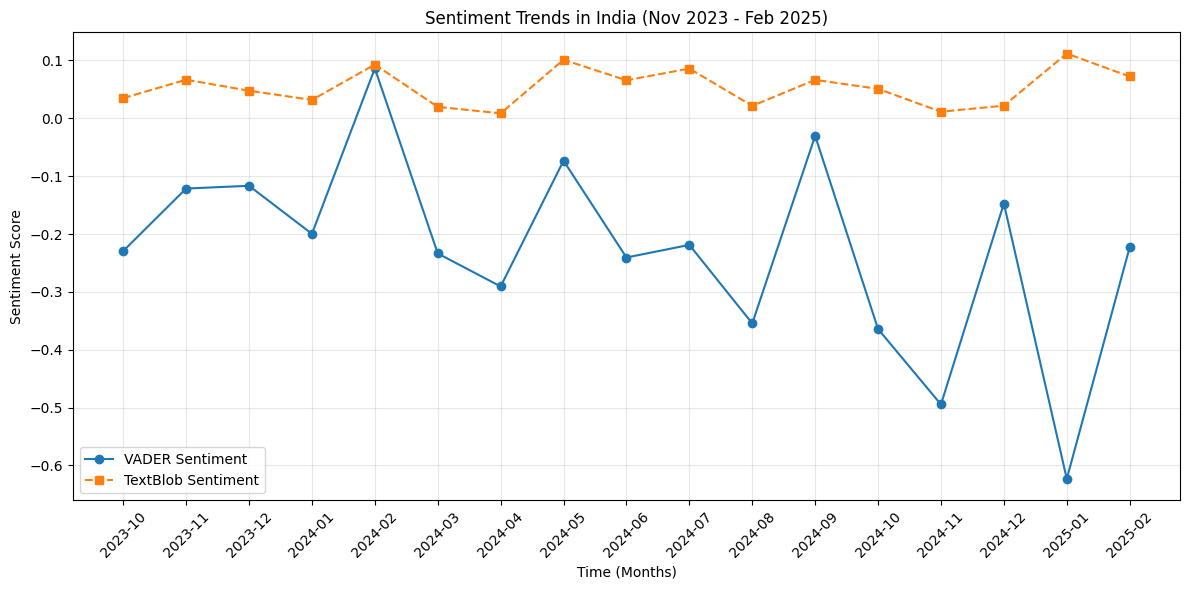

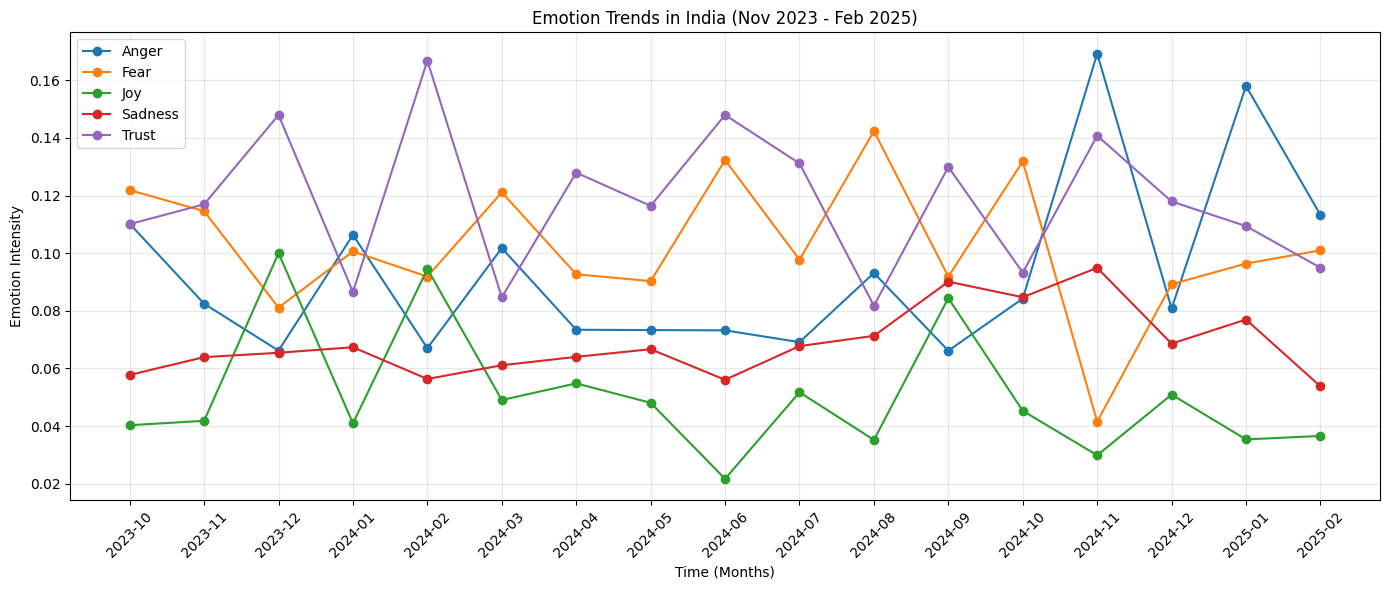

Analysis completed for India

===== Analyzing Egypt data =====
Loading data for Egypt...
Available columns for Egypt: ['Type', 'Subreddit', 'Title', 'Author', 'Date', 'URL', 'Text', 'Upvotes', 'Comments']
Analyzing sentiment for Egypt...
Analyzing emotions for Egypt...
Extracting emotions from comments for Egypt...
Aggregating data by month for Egypt...


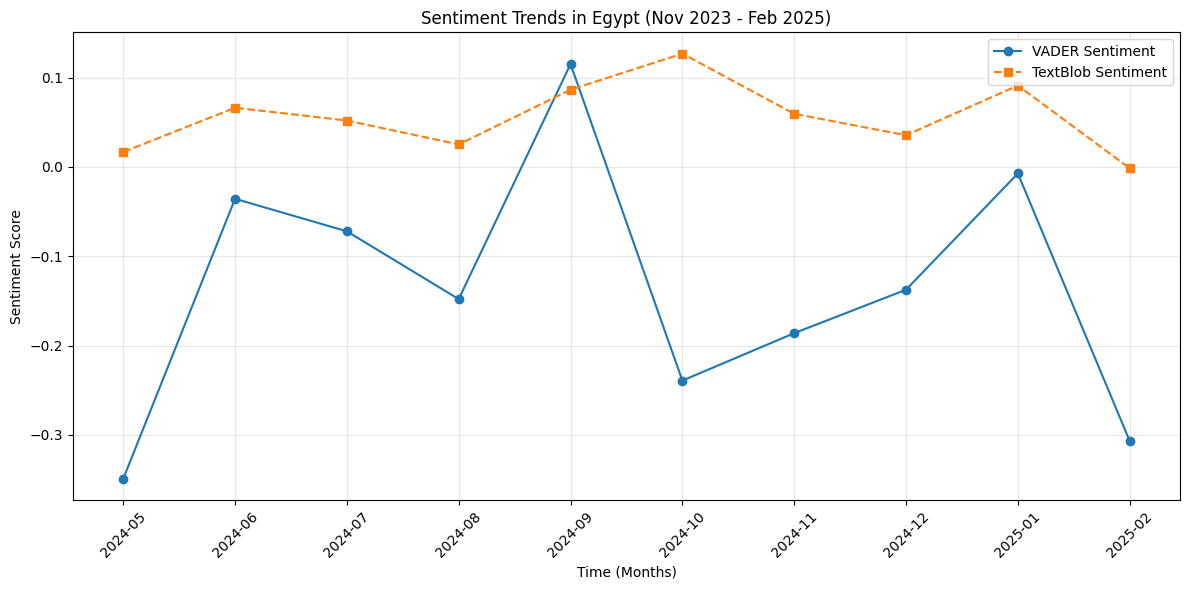

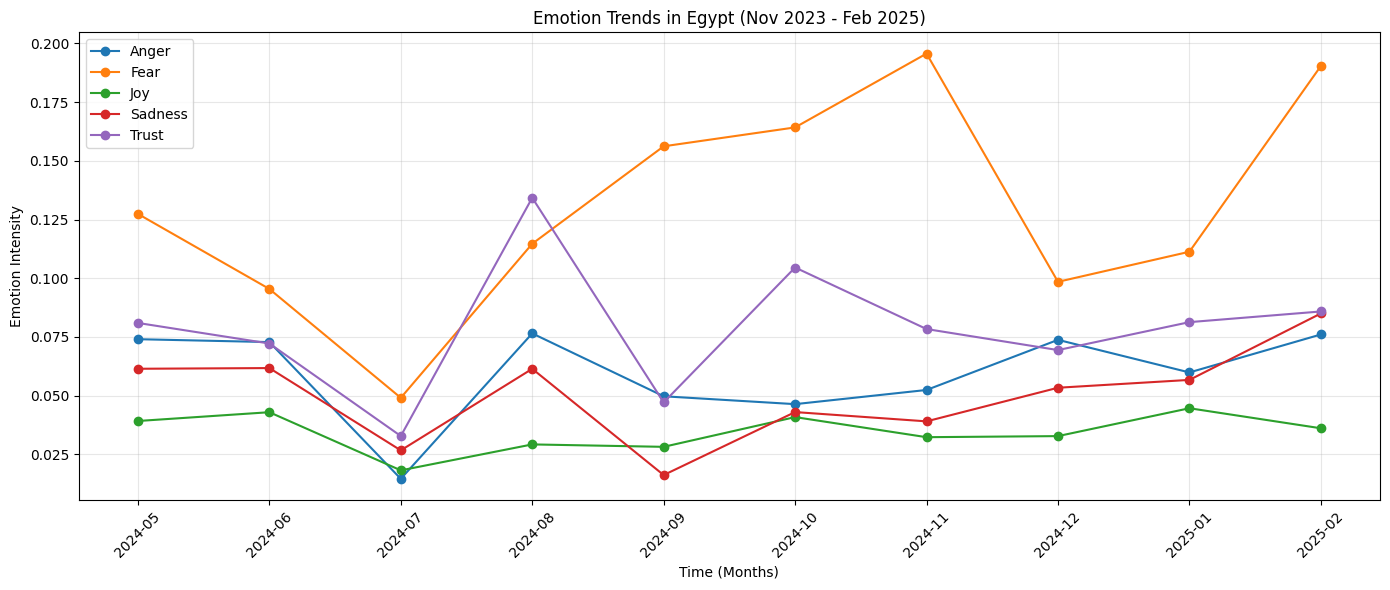

Analysis completed for Egypt

===== Analyzing Jordan data =====
Loading data for Jordan...
Available columns for Jordan: ['Type', 'Subreddit', 'Title', 'Author', 'Date', 'URL', 'Text', 'Upvotes', 'Comments']
Analyzing sentiment for Jordan...
Analyzing emotions for Jordan...
Extracting emotions from comments for Jordan...
Aggregating data by month for Jordan...


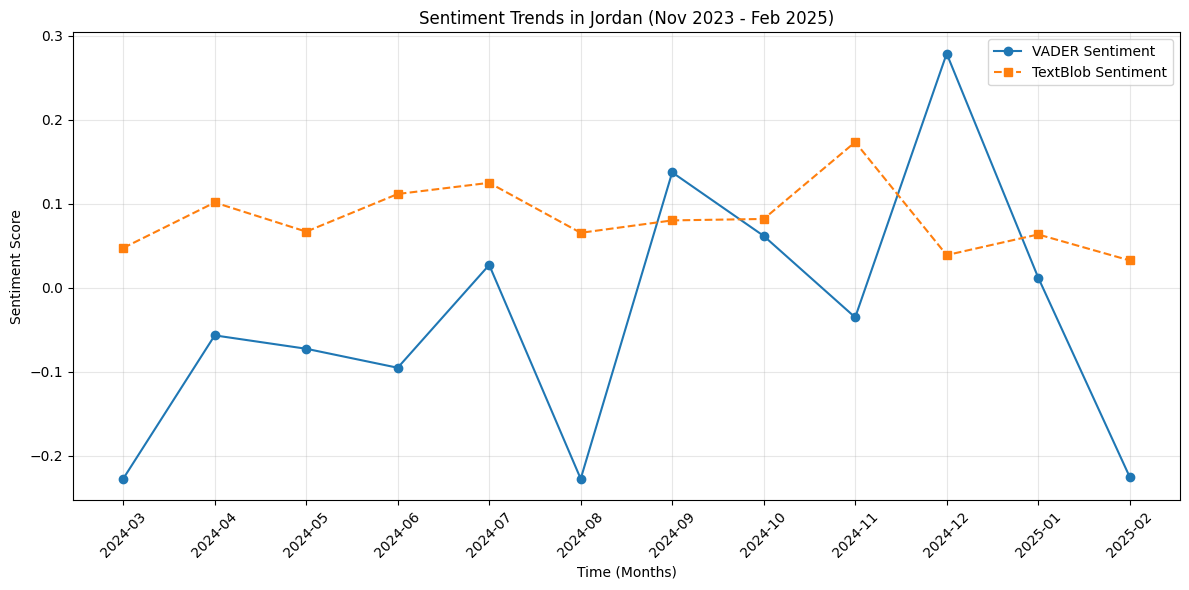

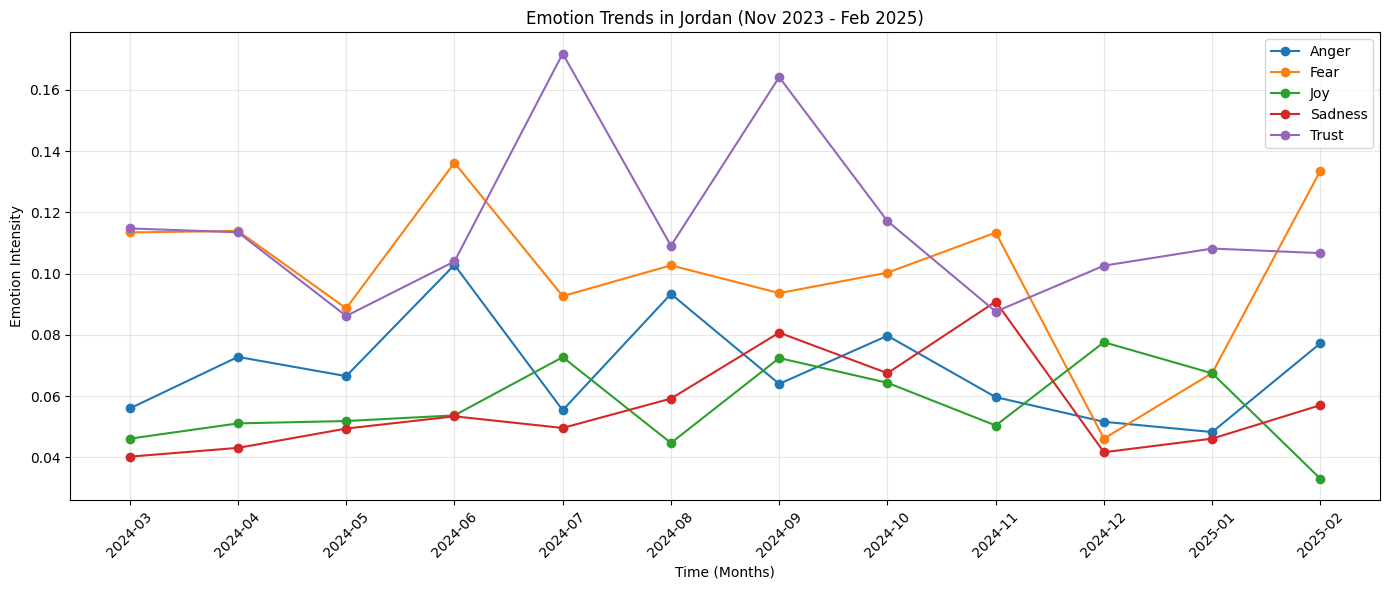

Analysis completed for Jordan

India Sentiment & Emotion Data (Aggregated Monthly):
            vader_compound  textblob_polarity     anger      fear       joy  \
year_month                                                                    
2023-10          -0.229390           0.034773  0.110201  0.121895  0.040275   
2023-11          -0.121397           0.066732  0.082462  0.114584  0.041805   
2023-12          -0.116670           0.047670  0.066180  0.081117  0.100015   
2024-01          -0.199709           0.031748  0.106364  0.100614  0.040956   
2024-02           0.086373           0.092885  0.067030  0.091865  0.094536   

             sadness     trust  
year_month                      
2023-10     0.057739  0.110084  
2023-11     0.063907  0.116966  
2023-12     0.065430  0.147977  
2024-01     0.067346  0.086524  
2024-02     0.056335  0.166825  

Egypt Sentiment & Emotion Data (Aggregated Monthly):
            vader_compound  textblob_polarity     anger      fear       joy  

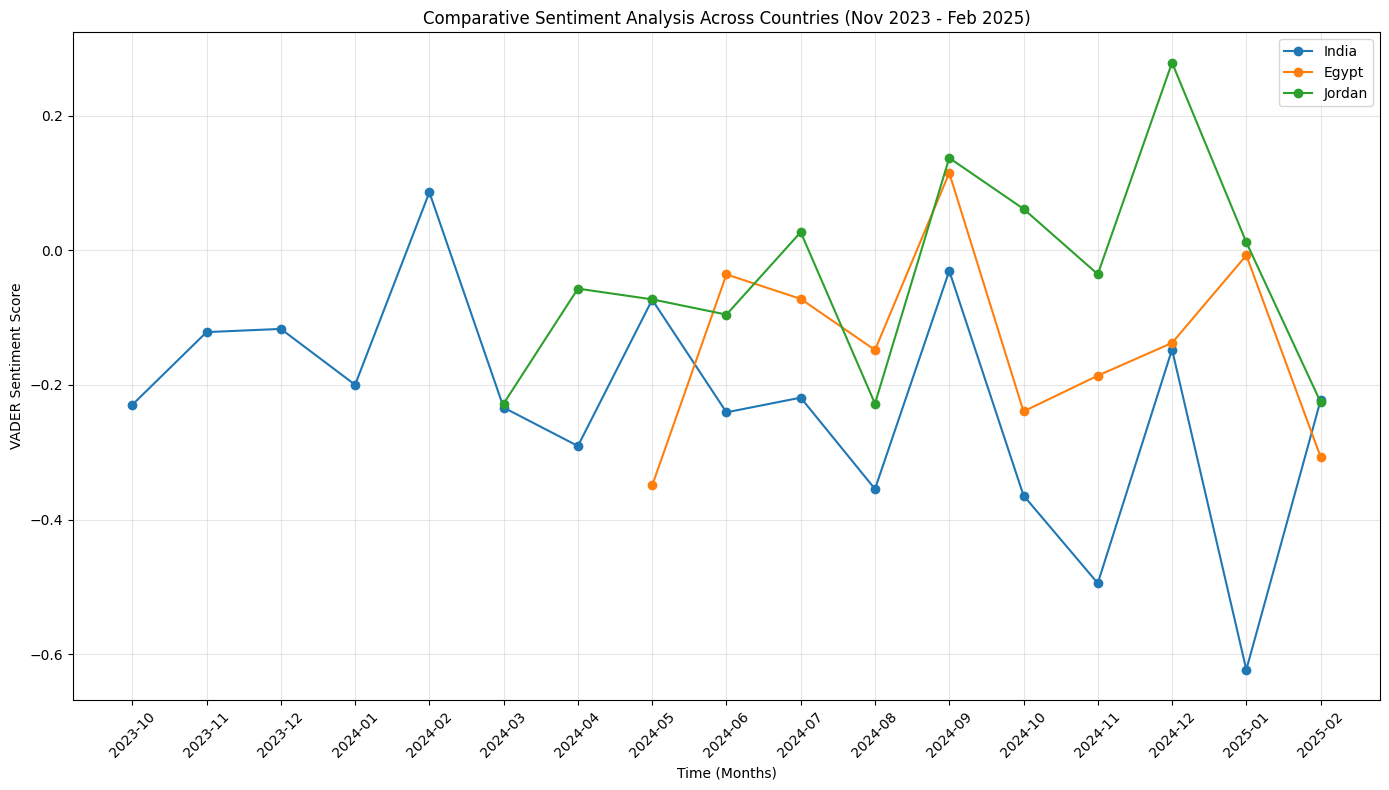


Results saved to sentiment_emotion_analysis_results.xlsx
Visualizations saved as PNG files in the current directory


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import sys
import subprocess
import numpy as np

# Install required packages
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nrclex"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl"])  # For Excel file support
except:
    print("Unable to install packages. Continuing with existing installations.")

# Now import NRCLex after installation
try:
    from nrclex import NRCLex
except ImportError:
    print("NRCLex installation failed. Some emotion analysis features may not work.")

# Download required NLTK data
try:
    nltk.download('vader_lexicon', quiet=True)
except:
    print("Unable to download NLTK data. Continuing with existing installations.")

# File paths for each country
file_paths = {
    "India": "/kaggle/input/new007/India_data.xlsx",
    "Egypt": "/kaggle/input/new007/Egypt_data.xlsx",
    "Jordan": "/kaggle/input/new007/Jordan_data.xlsx"
}

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to process and analyze sentiment & emotion
def analyze_sentiment_emotion(file_path, country):
    print(f"Loading data for {country}...")
    # Load dataset
    df = pd.read_excel(file_path)
    
    print(f"Available columns for {country}: {df.columns.tolist()}")
    
    # Based on the Excel inspection, we know the columns are:
    # 'Type', 'Subreddit', 'Title', 'Author', 'Date', 'URL', 'Text', 'Upvotes', 'Comments'
    
    # Convert date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # For sentiment analysis, use 'Title' and 'Text' (if available)
    # Create a combined text field
    df['comment'] = df['Title'].fillna('')
    if 'Text' in df.columns:
        # Combine Title and Text, handle NaN values
        df['comment'] = df.apply(
            lambda row: row['comment'] + ' ' + str(row['Text']) if pd.notna(row['Text']) else row['comment'], 
            axis=1
        )
    
    print(f"Analyzing sentiment for {country}...")
    # VADER Sentiment Analysis
    df['vader_compound'] = df['comment'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    
    # TextBlob Sentiment
    df['textblob_polarity'] = df['comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    
    print(f"Analyzing emotions for {country}...")
    # Emotion Analysis using NRCLex
    def get_emotions(text):
        try:
            emotions = NRCLex(str(text)).affect_frequencies
            # Extract only the emotions we're interested in
            emotion_dict = {
                'anger': emotions.get('anger', 0),
                'fear': emotions.get('fear', 0),
                'joy': emotions.get('joy', 0),
                'sadness': emotions.get('sadness', 0),
                'disgust': emotions.get('disgust', 0),
                'surprise': emotions.get('surprise', 0),
                'trust': emotions.get('trust', 0),
                'anticipation': emotions.get('anticipation', 0)
            }
            return emotion_dict
        except Exception as e:
            print(f"Error processing text: {str(e)[:50]}...")
            return {
                'anger': 0, 'fear': 0, 'joy': 0, 'sadness': 0,
                'disgust': 0, 'surprise': 0, 'trust': 0, 'anticipation': 0
            }
    
    # Apply emotion analysis with error handling
    print(f"Extracting emotions from comments for {country}...")
    # Process emotions row by row to avoid DataFrame concatenation issues
    for emotion in ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise', 'trust', 'anticipation']:
        df[emotion] = 0.0  # Initialize with zeros
    
    # Process each row
    for i, row in df.iterrows():
        try:
            emotions = get_emotions(row['comment'])
            for emotion, value in emotions.items():
                df.at[i, emotion] = value
        except Exception as e:
            print(f"Error processing row {i}: {str(e)[:30]}...")
    
    # Ensure numeric types for aggregation
    numeric_cols = ['vader_compound', 'textblob_polarity', 'anger', 'fear', 'joy', 
                   'sadness', 'disgust', 'surprise', 'trust', 'anticipation']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    # Aggregate sentiment over time
    print(f"Aggregating data by month for {country}...")
    # Group by year and month
    df['year_month'] = df['Date'].dt.to_period('M')
    
    # Calculate aggregates manually to avoid issues
    grouped_data = []
    for period, group in df.groupby('year_month'):
        row_data = {'year_month': period}
        for col in numeric_cols:
            row_data[col] = group[col].mean()
        grouped_data.append(row_data)
    
    # Create a new DataFrame from the aggregated data
    df_grouped = pd.DataFrame(grouped_data)
    df_grouped.set_index('year_month', inplace=True)
    
    # Plot Sentiment Trends
    plt.figure(figsize=(12, 6))
    plt.plot(df_grouped.index.astype(str), df_grouped['vader_compound'], marker='o', label='VADER Sentiment')
    plt.plot(df_grouped.index.astype(str), df_grouped['textblob_polarity'], marker='s', label='TextBlob Sentiment', linestyle='dashed')
    plt.xticks(rotation=45)
    plt.title(f"Sentiment Trends in {country} (Nov 2023 - Feb 2025)")
    plt.xlabel("Time (Months)")
    plt.ylabel("Sentiment Score")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{country}_sentiment_trends.png")
    plt.show()
    
    # Plot Emotion Trends
    plt.figure(figsize=(14, 6))
    for emotion in ['anger', 'fear', 'joy', 'sadness', 'trust']:
        plt.plot(df_grouped.index.astype(str), df_grouped[emotion], marker='o', label=emotion.capitalize())
    plt.xticks(rotation=45)
    plt.title(f"Emotion Trends in {country} (Nov 2023 - Feb 2025)")
    plt.xlabel("Time (Months)")
    plt.ylabel("Emotion Intensity")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{country}_emotion_trends.png")
    plt.show()
    
    return df_grouped

# Run the analysis for each country
results = {}
for country, path in file_paths.items():
    print(f"\n===== Analyzing {country} data =====")
    try:
        results[country] = analyze_sentiment_emotion(path, country)
        print(f"Analysis completed for {country}")
    except Exception as e:
        print(f"Error analyzing {country} data: {str(e)}")
        # Create a placeholder DataFrame so we have something to write to Excel
        results[country] = pd.DataFrame({
            'vader_compound': [0], 
            'textblob_polarity': [0],
            'anger': [0], 
            'fear': [0], 
            'joy': [0], 
            'sadness': [0], 
            'trust': [0]
        })

# Display the processed data
for country, df in results.items():
    print(f"\n{country} Sentiment & Emotion Data (Aggregated Monthly):")
    print(df[['vader_compound', 'textblob_polarity', 'anger', 'fear', 'joy', 'sadness', 'trust']].head())

# Comparative analysis across countries
print("\n===== Comparative Analysis =====")

# Prepare data for comparison - handle potential empty DataFrames
comparison_data = pd.DataFrame()
for country, df in results.items():
    if not df.empty and 'vader_compound' in df.columns:
        temp_df = pd.DataFrame({country: df['vader_compound']})
        temp_df.index = df.index if hasattr(df.index, 'astype') else pd.period_range(start='2023-11', periods=len(df), freq='M')
        
        if comparison_data.empty:
            comparison_data = temp_df
        else:
            # Use outer join to include all periods
            comparison_data = comparison_data.join(temp_df, how='outer')

# Plot comparison if we have data
if not comparison_data.empty:
    plt.figure(figsize=(14, 8))
    for country in file_paths.keys():
        if country in comparison_data.columns:
            plt.plot(comparison_data.index.astype(str), comparison_data[country], marker='o', label=country)
    plt.xticks(rotation=45)
    plt.title("Comparative Sentiment Analysis Across Countries (Nov 2023 - Feb 2025)")
    plt.xlabel("Time (Months)")
    plt.ylabel("VADER Sentiment Score")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("comparative_sentiment_analysis.png")
    plt.show()
else:
    print("No data available for comparative analysis")

# Ensure we have at least one sheet to write to Excel
if all(df.empty for df in results.values()):
    # Create a dummy DataFrame if all results are empty
    results["Summary"] = pd.DataFrame({
        'country': list(file_paths.keys()),
        'status': ['No data available'] * len(file_paths)
    })

# Save results to Excel
output_file = "sentiment_emotion_analysis_results.xlsx"
with pd.ExcelWriter(output_file) as writer:
    for country, df in results.items():
        df.to_excel(writer, sheet_name=country[:31])  # Excel sheet names limited to 31 chars
    if not comparison_data.empty:
        comparison_data.to_excel(writer, sheet_name="Comparison")

print(f"\nResults saved to {output_file}")
print(f"Visualizations saved as PNG files in the current directory")